# Bayesian DAE vs Traditional DAE (Linear)


## Data loading and processing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
!pip install -q tensorflow
%load_ext tensorboard

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
trainval_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [4]:
train_data, val_data = random_split(trainval_data, [50_000, 10_000])

# how many samples per batch to load
batch_size = 64

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

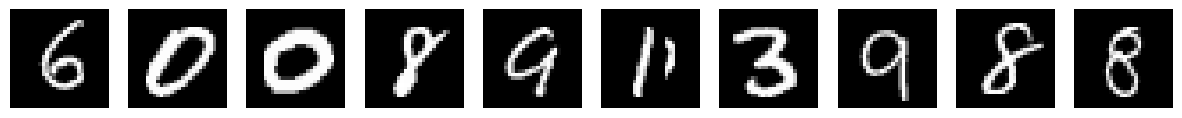

In [5]:
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

## Autoencoder Architectures

In [6]:
dropout_rate = 0.3

def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

class LinearBDAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 512)
        self.enc_fc2 = nn.Linear(512, 256)
        self.enc_fc3 = nn.Linear(256, 128)

        # Decoder layers
        self.dec_fc1 = nn.Linear(128, 256)
        self.dec_fc2 = nn.Linear(256, 512)
        self.dec_fc3 = nn.Linear(512, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var


class LinearDAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 512)
        self.enc_fc2 = nn.Linear(512, 256)
        self.enc_fc3 = nn.Linear(256, 128)

        # Decoder layers
        self.dec_fc1 = nn.Linear(128, 256)
        self.dec_fc2 = nn.Linear(256, 512)
        self.dec_fc3 = nn.Linear(512, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var

## Noise schemes

In [7]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

def add_masking_noise(images, masking_rate=0.5):
    # Generate a random mask with the same shape as the images
    mask = torch.rand_like(images) > masking_rate
    # Apply the mask to the images
    noisy_images = images * mask
    return noisy_images

def add_salt_pepper_noise(images, pepper_prob=0.1, salt_prob=None):
    noisy_img = images.clone()
    if salt_prob is None:
        salt_prob = 1 - pepper_prob
    # Generating random noise mask
    noise_mask = torch.rand_like(images)
    # Adding pepper noise
    noisy_img[noise_mask < pepper_prob] = 0
    # Adding salt noise
    noisy_img[noise_mask > salt_prob] = 1
    return noisy_img

def add_gaussian_blur(images, kernel_size=5, sigma=2):

    blurred_images = []
    for image in images:
        # Convert tensor to PIL image
        image_pil = TF.to_pil_image(image.view(-1, 28, 28))

        # Apply Gaussian blur
        blurred_image_pil = TF.gaussian_blur(image_pil, kernel_size, sigma)

        # Convert blurred image back to tensor
        blurred_image_tensor = TF.to_tensor(blurred_image_pil)

        blurred_images.append(blurred_image_tensor)

    return torch.stack(blurred_images).view(-1, 28*28)


add_noise = lambda images: add_gaussian_noise(images, noise_factor=0.3)

## Training Process

### Training functions

In [8]:
def train(train_loader, net, optimizer, criterion):
  total_loss = 0

  for i, data in enumerate(train_loader):

        images, _ = data
        images = images.view(images.size(0), -1)

        # ADD NOISE PROCESS
        corrupted_images = add_noise(images)

        images = images.to(device)
        corrupted_images = corrupted_images.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(corrupted_images)

        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        total_loss += loss.item() * images.size(0)

  avg_loss = total_loss/len(train_loader.dataset)  # Compute average loss

  return avg_loss

In [9]:
def validation(val_loader, net, criterion, Nsamples):
  total_loss = 0

  # Use torch.no_grad to skip gradient calculation, not needed for evaluation
  with torch.no_grad():
      # iterate through batches
        for data in val_loader:
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            # images = images.to(device)
            images = images.view(images.size(0), -1)

            corrupted_images = add_noise(images)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # keep track of loss and accuracy
            total_loss += loss.item() * images.size(0)

  return total_loss/len(val_loader.dataset)

### Training Procedure

##### DAE

In [92]:
# To completely clean your tensorboard uncomment and run the following command.
!rm -r runs
#Set random seed
torch.manual_seed(42)

train_losses = []
val_losses = []

# Create a writer to write to Tensorboard
writer = SummaryWriter()

traditional_linear_model = LinearDAE().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(traditional_linear_model.parameters(), lr=learning_rate)

num_epochs = 1

Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, traditional_linear_model, optimizer, criterion)

    # Test on data
    val_loss = validation(val_loader, traditional_linear_model, criterion, Nsamples)

    # Log metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss, 'Validation':val_loss}, epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print('Finished Training')

#Close the writer
writer.flush()
writer.close()

100%|██████████| 1/1 [00:38<00:00, 38.17s/it]

Finished Training


##### BDAE

In [11]:
# To completely clean your tensorboard uncomment and run the following command.
!rm -r runs
#Set random seed
torch.manual_seed(42)

train_losses = []
val_losses = []

# Create a writer to write to Tensorboard
writer = SummaryWriter()

bayesian_linear_model = LinearBDAE().to(device)
criterion = nn.MSELoss()
# learning_rate = 1e-3 #Should already be specified
optimizer = torch.optim.Adam(bayesian_linear_model.parameters(), lr=learning_rate)

# num_epochs = 1 #Should already be specified

Nsamples = 10

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, bayesian_linear_model, optimizer, criterion)

    # Test on data
    val_loss = validation(val_loader, bayesian_linear_model, criterion, Nsamples)

    # Log metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss, 'Validation':val_loss}, epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print('Finished Training')

#Close the writer
writer.flush()
writer.close()

100%|██████████| 1/1 [00:34<00:00, 34.48s/it]

Finished Training


## Visualizations Linear

### Clean images

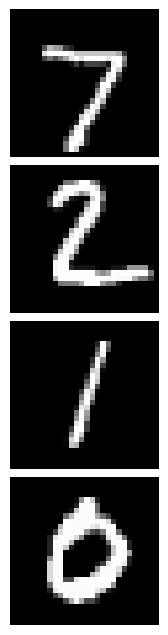

In [107]:
num_images = 4

# Function to plot the images
def plot_images(images, space=0.05, cmap='gray'):
    plt.figure(figsize=(2, 8))
    for i in range(num_images):
        plt.subplot(4, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()


# Initialize images
# Get a different set of 8 images and their labels from the test dataset
start_index = 0  # Change this to select a different starting point
images, labels = zip(*[(test_data[i][0], test_data[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(images, 0.05)

# # Plot corrupted images
# torch_images = torch.stack(images)

# noisy_images = add_noise(torch_images)
# plot_images(noisy_images, 0.05)

# # Plot DAE output

# # Plot BDAE output

# noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1)
# bayesian_linear_model.eval()
# with torch.no_grad():
#     _, predictions_mean, predictions_var = bayesian_linear_model.sample_predict(noisy_images_flattened, 10)

# plot_images(predictions_mean.view(-1,28,28), 0.05)
# plot_images(predictions_var.view(-1,28,28), 0.05, 'viridis')



### Corrupted images

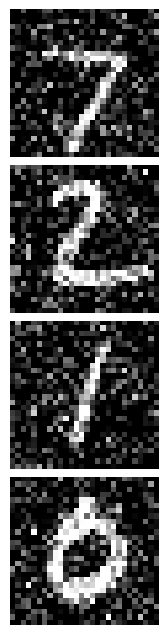

In [108]:
torch_images = torch.stack(images)

noisy_images = add_noise(torch_images)
plot_images(noisy_images, 0.05)

### Predictions DAE

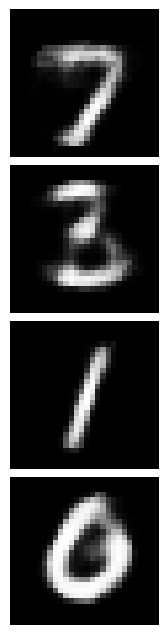

In [109]:
noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1)
bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = traditional_linear_model.sample_predict(noisy_images_flattened, 10)

plot_images(predictions_mean.view(-1,28,28), 0.05)

### Mean BDAE

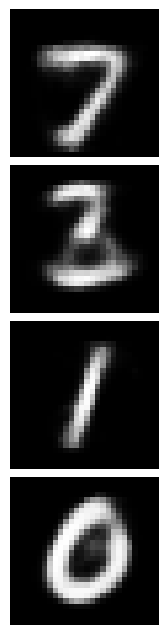

In [110]:
noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1)
bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = bayesian_linear_model.sample_predict(noisy_images_flattened, 10)

plot_images(predictions_mean.view(-1,28,28), 0.05)

### Variance BDAE

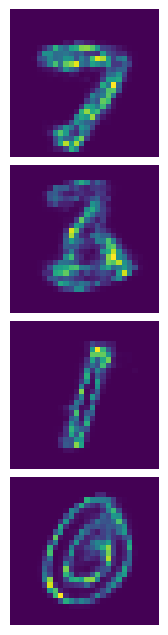

In [111]:
plot_images(predictions_var.view(-1,28,28), 0.05, 'viridis')